In [170]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
!pip install exp_hurst
!pip install mmq

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import csv
import os
import pickle
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error as MAE
from exp_hurst.exp_hurst import hurst
from scipy.stats import kurtosis

# Real Data Processing (run again)

In [173]:
df = pd.read_excel('/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ETH-data.xlsx')
df


,date,open price,high price,low price,close price,active address,active address received,active address sent,supply,token per active address,average fee,median fee,fee revenue percentage,total fee,total revenue,revenue per active address
0,08/07/2020,394.940,398.290,366.300,379.570,529429.0,396933.0,396718,112100000,211.737551,1.73,0.869,0.2944,2160000,635904.000000,1.602912
1,08/06/2020,400.910,403.360,391.820,395.000,582260.0,424157.0,420400,112100000,192.525676,1.45,0.715,0.2453,1760000,431728.000000,1.026946
2,08/05/2020,389.770,407.230,384.220,401.160,611242.0,458809.0,413144,112000000,183.233482,1.38,0.665,0.2308,1630000,376204.000000,0.910588
3,08/04/2020,386.230,402.700,382.880,389.520,594577.0,435381.0,408263,112000000,188.369210,1.46,0.707,0.2437,1710000,416727.000000,1.020732
4,08/03/2020,372.400,397.970,368.830,386.140,575598.0,432594.0,402324,112000000,194.580245,1.72,0.828,0.2771,2020000,559742.000000,1.391272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,08/11/2015,0.665,1.160,0.651,1.070,2697.0,2538.0,2144,60400000,22395.253986,0.00226,0.00121,0.0004,11.2,0.004480,0.000002
1824,08/10/2015,0.652,0.766,0.647,0.698,1430.0,1279.0,839,60400000,42237.762238,0.0184,0.00147,0.0011,37.4,0.041140,0.000049
1825,08/09/2015,0.721,0.827,0.696,0.784,1113.0,939.0,473,60400000,54267.744834,0.0127,0.00147,0.0005,16.92,0.008460,0.000018
1826,08/08/2015,1.650,2.000,0.900,0.910,1208.0,958.0,619,60100000,49751.655629,0.0284,0.00149,0.0024,81.72,0.196128,0.000317


In [174]:
selected_columns = ['date', 'close price', 'active address', 'supply', 'token per active address', 'revenue per active address']
sel_df = df[selected_columns]
sel_df = sel_df[::-1].reset_index(drop=True)[:-1]
sel_df.fillna(method='ffill', inplace=True)
sel_df


,date,close price,active address,supply,token per active address,revenue per active address
0,08/07/2015,2.950,1390.0,72300000,52014.388489,0.000000
1,08/08/2015,0.910,1208.0,60100000,49751.655629,0.000317
2,08/09/2015,0.784,1113.0,60400000,54267.744834,0.000018
3,08/10/2015,0.698,1430.0,60400000,42237.762238,0.000049
4,08/11/2015,1.070,2697.0,60400000,22395.253986,0.000002
...,...,...,...,...,...,...
1822,08/02/2020,372.240,626146.0,112000000,178.872020,1.657501
1823,08/03/2020,386.140,575598.0,112000000,194.580245,1.391272
1824,08/04/2020,389.520,594577.0,112000000,188.369210,1.020732
1825,08/05/2020,401.160,611242.0,112000000,183.233482,0.910588


In [175]:
sel_df.isna().sum()

,0
date,0
close price,0
active address,0
supply,0
token per active address,0
revenue per active address,0


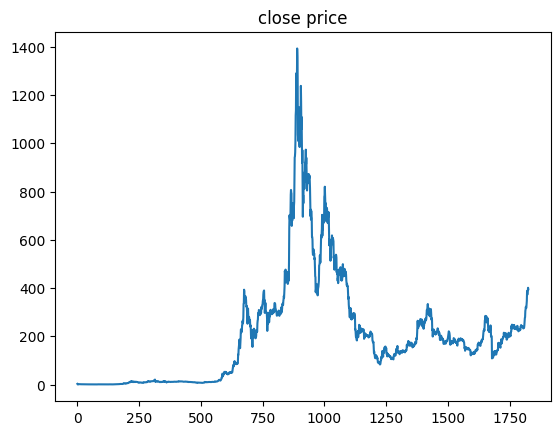

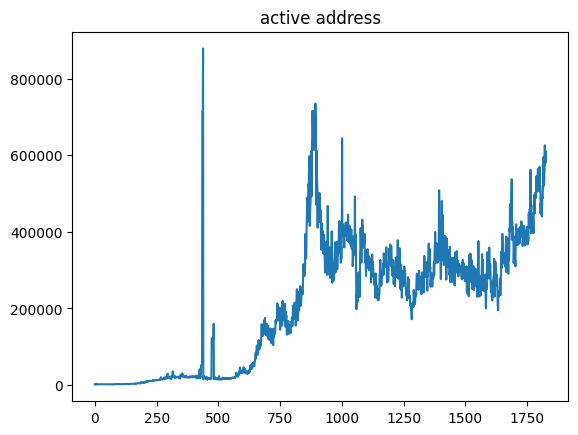

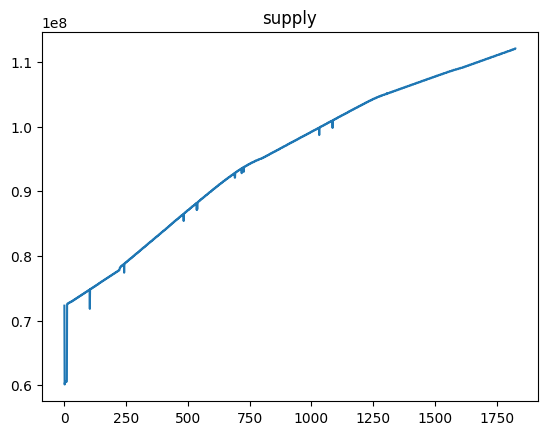

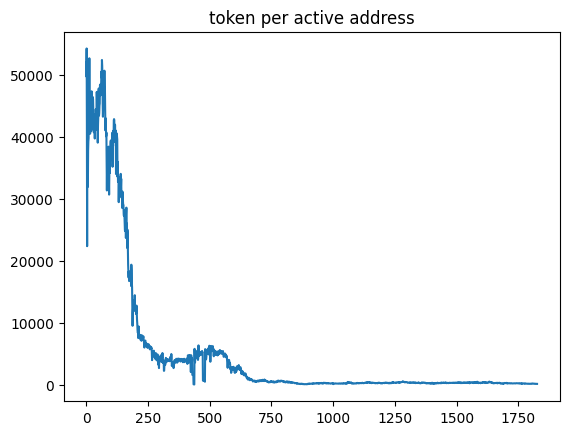

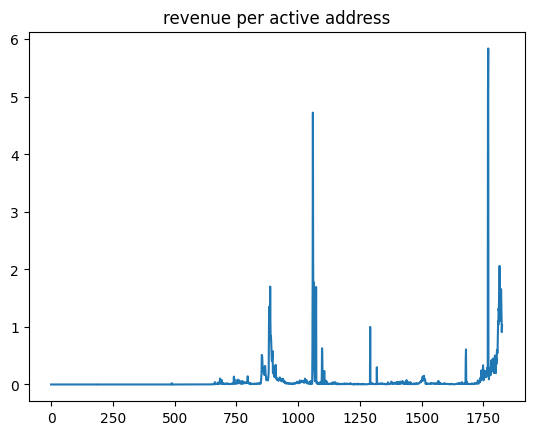

In [176]:
for col in sel_df.columns:
    if col != "date":
        plt.plot(sel_df[col])
        plt.title(col)
        plt.show()

In [177]:
sel_df['date'] = pd.to_datetime(sel_df['date'], format='%m/%d/%Y')
sel_df['group'] = (sel_df['date'] - pd.Timedelta(days=6)).dt.to_period('M')
agg_dict = {
    'date': ['min', 'max'],
    'close price': 'last',
    'active address': 'first',
    'supply': 'first',
    'token per active address': 'first',
    'revenue per active address': 'sum'
}
grouped_df = sel_df.groupby('group').agg(agg_dict)
grouped_df.columns = [
    'start_date', 'end_date',
    'close price', 'active address',
    'supply', 'token per active address',
    'revenue per active address'
]
grouped_df = grouped_df.reset_index(drop=True)
grouped_df['date'] = (
    grouped_df['start_date'].dt.strftime('%m/%d/%Y') +
    ' - ' +
    grouped_df['end_date'].dt.strftime('%m/%d/%Y')
)
cols = ['date', 'close price', 'active address', 'supply',
        'token per active address', 'revenue per active address']
grouped_df = grouped_df[cols]
grouped_df

,date,close price,active address,supply,token per active address,revenue per active address
0,08/07/2015 - 09/06/2015,1.300,1390.0,72300000,52014.388489,0.000735
1,09/07/2015 - 10/06/2015,0.653,1791.0,73000000,40759.352317,0.000104
2,10/07/2015 - 11/06/2015,0.944,1512.0,73700000,48743.386243,0.000132
3,11/07/2015 - 12/06/2015,0.840,2265.0,74500000,32891.832230,0.000212
4,12/07/2015 - 01/06/2016,0.957,2057.0,75300000,36606.708799,0.001481
5,01/07/2016 - 02/06/2016,2.520,2788.0,76100000,27295.552367,0.003867
6,02/07/2016 - 03/06/2016,11.310,4143.0,76800000,18537.291818,0.003121
7,03/07/2016 - 04/06/2016,10.670,8216.0,77600000,9444.985394,0.001929
8,04/07/2016 - 05/06/2016,9.360,11965.0,78800000,6585.875470,0.000898
9,05/07/2016 - 06/06/2016,13.930,14378.0,79800000,5550.146056,0.001440


# Fixed Parameter Determination (no need to run)

In [ ]:
# @title Annual Revenue per User
sel_df["revenue per active address"].sum() / 5

23.67619594814291

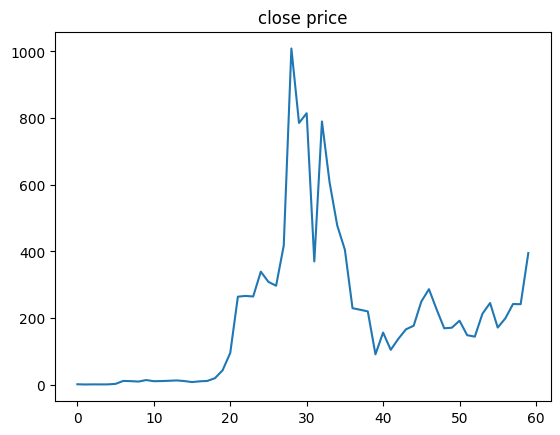

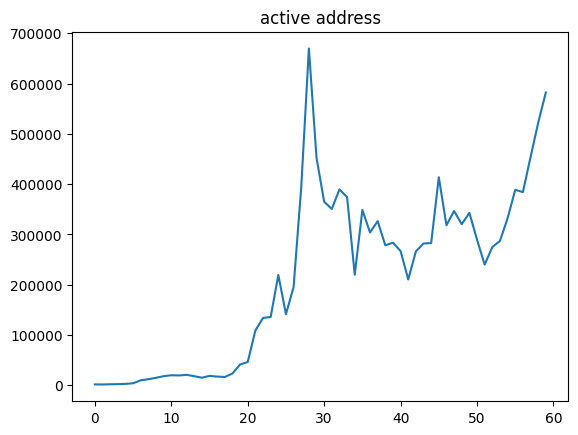

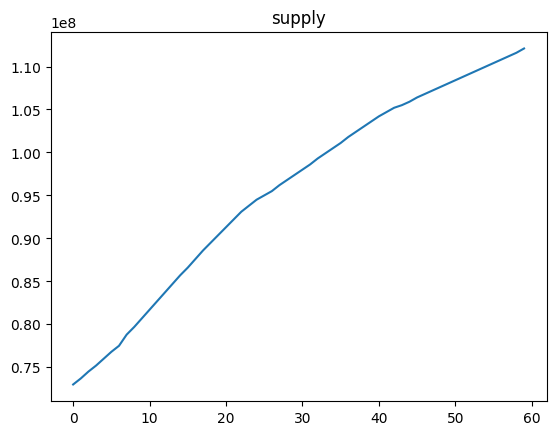

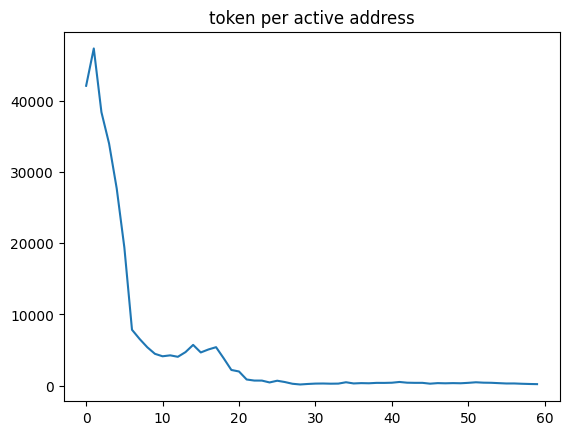

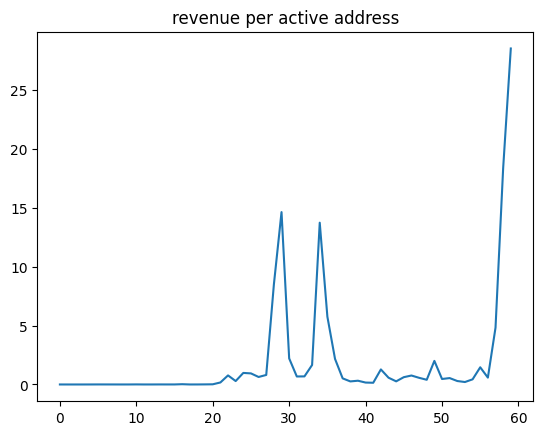

In [ ]:
for col in grouped_df.columns:
    if col != "date":
        plt.plot(grouped_df[col])
        plt.title(col)
        plt.show()

In [ ]:
# @title Initial Token Supply
sel_df['supply'][0] / (sel_df['active address'][0] / 100)

5201438.848920863

In [ ]:
# @title Initial Price
df['open price'][1827]

3.0

Fitted parameters: [ 6234.13173191 54592.74306914  5327.49443937   324.0944231
   239.20867425]
MAE: 24165.420899710592


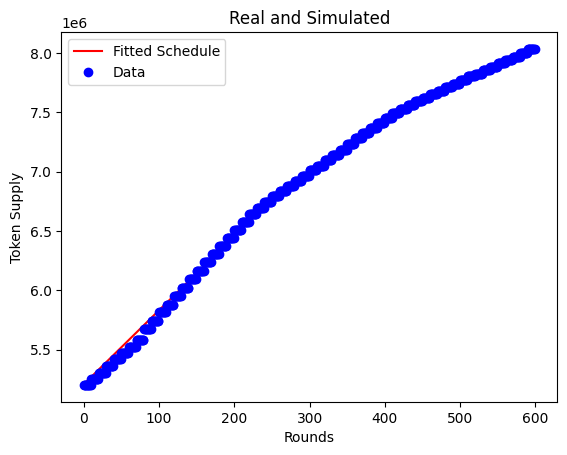

In [ ]:
# @title Supply Schedule Parameters
from scipy.optimize import minimize
import matplotlib.pyplot as plt

global y_data, initial_amount
y_data = []
for i in range(len(grouped_df['supply'])):
    for j in range(10):
        y_data.append(grouped_df['supply'][i] / (sel_df['active address'][0] / 100))
y_data = np.array(y_data)

initial_amount = 5201438

def s_curve_model(r1, t1, r2, t2, t_switch):
    # Use the length of y_data to define time points as 1, 2, 3, ..., len(y_data)
    t = np.arange(1, len(y_data) + 1)
    ln2 = np.log(2)
    cum = np.empty_like(t, dtype=float)
    mask = t < t_switch
    cum[mask] = initial_amount + (r1 * t1 / ln2) * (2**(t[mask] / t1) - 1)
    mask2 = ~mask
    cum_switch = initial_amount + (r1 * t1 / ln2) * (2**(t_switch / t1) - 1)
    cum[mask2] = cum_switch + (r2 * t2 / ln2) * (1 - (1/2)**((t[mask2] - t_switch) / t2))
    return cum

def objective(params):
    r1, t1, r2, t2, t_switch = params
    y_model = s_curve_model(r1, t1, r2, t2, t_switch)
    return np.mean(np.abs(y_model - y_data))

bounds = [(0, None)] * 5
initial_guess = [6234.13161078, 54592.74303301, 5327.49434713, 324.09396204, 239.20750524]
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)
params_fit = result.x

print("Fitted parameters:", params_fit)
print("MAE:", objective(params_fit))

plt.plot(s_curve_model(*params_fit), 'r-', label='Fitted Schedule')
plt.plot(y_data, 'bo', label='Data')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Token Supply')
plt.title('Real and Simulated')
plt.show()


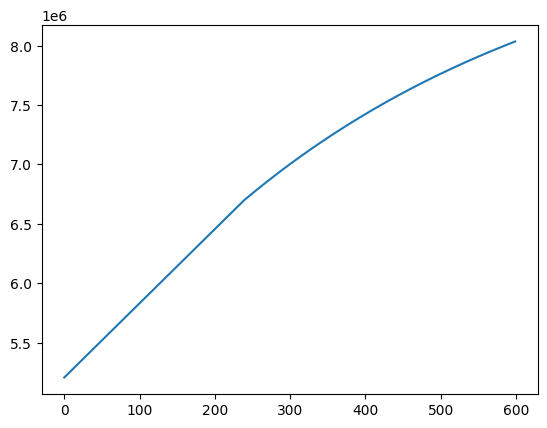

In [ ]:
plt.plot(s_curve_model(*params_fit))

In [ ]:
s_curve_model(*params_fit)[-1]

8034463.723538591

In [ ]:
y_data[-1]

8035971.223021583

In [ ]:
del y_data, initial_amount

Fitted parameters: [8.31137145e+00 9.92567141e+02 6.03736513e+01 9.99994059e+03
 1.16579825e+02]
MAE: 4092.6142574506657


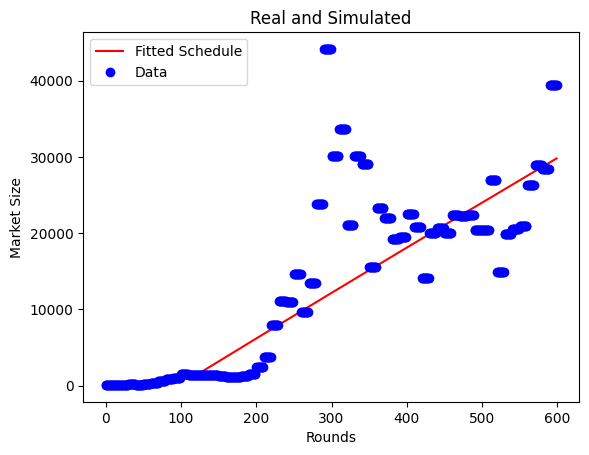

In [ ]:
# @title Market Growth Parameters
global y_data, initial_amount
y_data = []
for i in range(len(grouped_df['active address'])):
    for j in range(10):
        y_data.append(grouped_df['active address'][i] / (sel_df['active address'][0] / 100))
y_data = np.array(y_data)

initial_amount = 100

def s_curve_model(r1, t1, r2, t2, t_switch):
    # Use the length of y_data to define time points as 1, 2, 3, ..., len(y_data)
    t = np.arange(1, len(y_data) + 1)
    ln2 = np.log(2)
    cum = np.empty_like(t, dtype=float)
    mask = t < t_switch
    cum[mask] = initial_amount + (r1 * t1 / ln2) * (2**(t[mask] / t1) - 1)
    mask2 = ~mask
    cum_switch = initial_amount + (r1 * t1 / ln2) * (2**(t_switch / t1) - 1)
    cum[mask2] = cum_switch + (r2 * t2 / ln2) * (1 - (1/2)**((t[mask2] - t_switch) / t2))
    return cum

def objective(params):
    r1, t1, r2, t2, t_switch = params
    y_model = s_curve_model(r1, t1, r2, t2, t_switch)
    return np.mean(np.abs(y_model - y_data))

bounds = [(0, None)] * 5
initial_guess = [10, 1000, 10, 10000, 250]
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)
params_fit = result.x

print("Fitted parameters:", params_fit)
print("MAE:", objective(params_fit))

plt.plot(s_curve_model(*params_fit), 'r-', label='Fitted Schedule')
plt.plot(y_data, 'bo', label='Data')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Market Size')
plt.title('Real and Simulated')
plt.show()


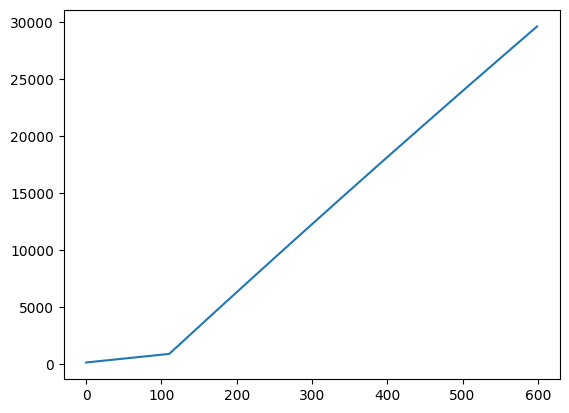

In [ ]:
plt.plot(s_curve_model(*params_fit))

In [ ]:
# prompt: list elements in interval of 10 filter inplace

# Assuming 'grouped_df' is the DataFrame you want to filter.
# Create a new DataFrame with elements at intervals of 10.

filtered_df = grouped_df.iloc[::10, :]

# If you want to modify 'grouped_df' in place:
# grouped_df = grouped_df.iloc[::10, :]


filtered_df


Text(0.5, 1.0, 'Real and Simulated')

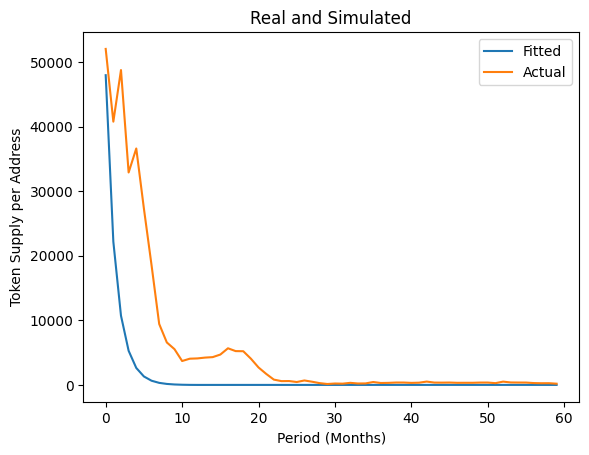

In [ ]:
def s_curve_model(r1, t1, r2, t2, t_switch, initial_amount):
    # Use the length of y_data to define time points as 1, 2, 3, ..., len(y_data)
    t = np.arange(1, len(y_data) + 1)
    ln2 = np.log(2)
    cum = np.empty_like(t, dtype=float)
    mask = t < t_switch
    cum[mask] = initial_amount + (r1 * t1 / ln2) * (2**(t[mask] / t1) - 1)
    mask2 = ~mask
    cum_switch = initial_amount + (r1 * t1 / ln2) * (2**(t_switch / t1) - 1)
    cum[mask2] = cum_switch + (r2 * t2 / ln2) * (1 - (1/2)**((t[mask2] - t_switch) / t2))
    return cum

plt.plot((s_curve_model(*[6234.13173191, 54592.74306914, 5327.49443937, 324.0944231, 239.20867425,  5201438])/s_curve_model(*[8.31137145e+00, 9.92567141e+0, 6.03736513e+01, 9.99994059e+03, 1.16579825e+02, 100]))[::10], label="Fitted")
plt.plot(np.array(grouped_df['supply']/grouped_df['active address']), label="Actual")
plt.legend()
plt.xlabel('Period (Months)')
plt.ylabel('Token Supply per Address')
plt.title('Real and Simulated')

# Calibration
Conducted 5 rounds. 200 parameter sets each rounds, 30 simulations conducted for each parameter set, and 5% survives the round and 20 neighbors for each survived parameter set are created for next round. Total of 30000 simulations conducted.

Stop Condition (or):
- (ticks = 600)
- ((min price-record) = 0)
- ((max price-record) > 10000)

Data Recorded:
- token-price
- last price-record
- token-trade-volume
- user-base
- platform-productivity
- unlocked-token-supply
- seed

In [ ]:
# @title Library
# --- Library and helper functions remain the same ---
all_params = {
    # calibration target
    "log10initial-productivity": (-10, 5),
    "productivity-mu": (-4, 4),
    "productivity-sigma": (0, 5),
    "transaction-need-std": (0, 5),

    # meta
    "intra-period-trading-rounds": 10,
    "maximum-optimization-step-size": 20,
    "scale": 1,

    # market env
    "initial-token-price": 3.00,
    "initial-user-base": 10,
    "token-unlock-ratio": 1.00,
    "risk-free-rate": 0.05,
    "annual-discount-rate": 0.3,
    "annual-per-user-revenue": 23.67,
    "participation-cost": 0,

    # agent
    "initial-return-belief": 0,
    "min-window-length": 7,
    "max-window-length": 365,

    # supply
    "initial-token-supply": 5201438,
    "supply-inflection-ticks": 239.20867425,
    "pre-token-issue-rate": 6234.13173191,
    "pre-supply_doubling_tick_length": 54592.74306914,
    "post-token-issue-rate": 5327.49443937,
    "post-supply_halving_tick_length": 324.0944231,
    "supply-cap": 100000000000,
    "supplied-via-reward": 0.5,
    "supplied-via-exchange": 0.5,

    # market growth
    "initial-serviceable-available-market": 100,
    "growth-inflection-ticks": 1.16579825e+02,
    "pre-market-growth-rate": 8.31137145e+00,
    "pre-inflection-market-doubling-ticks": 9.92567141e+02,
    "post-market-growth-rate": 6.03736513e+01,
    "post-inflection-market-halving-ticks": 9.99994059e+03,

    # not important
    "show-from": 10000,
    "schedule-horizon": 600
}

calib_params = [
    "log10initial-productivity",
    "productivity-mu",
    "productivity-sigma",
    "transaction-need-std",
]

real_price = grouped_df["close price"].to_numpy()  # as before
# (real_metrics will be redefined later)

# ------------------------------
# Example: unchanged function to create parameter sets
def create_parameter_sets(all_params, n_samples, params_list=None):
    keys_order = ["log10initial-productivity", "productivity-mu", "productivity-sigma", "transaction-need-std"]
    calibration_params = {key: bounds for key, bounds in all_params.items() if isinstance(bounds, tuple)}
    constant_params = {key: value for key, value in all_params.items() if key not in calibration_params}

    if params_list is None:
        sets = []
        for _ in range(n_samples):
            calib = {key: random.uniform(*calibration_params[key]) for key in calibration_params}
            calib.update(constant_params)
            sets.append(calib)
        return sets
    else:
        arr = np.array(params_list)
        stds = np.std(arr, axis=0, ddof=1)
        print(stds)
        sets = []
        for ps in params_list:
            for _ in range(n_samples):
                new_vals = []
                for i, val in enumerate(ps):
                    key = keys_order[i]
                    sigma = stds[i] if stds[i] != 0 else (calibration_params[key][1] - calibration_params[key][0]) / 10.0
                    new_val = np.random.normal(loc=val, scale=sigma)
                    if (i == 3) & (new_val < 0):
                        new_val = new_val * -1
                    new_vals.append(new_val)
                calib = {key: value for key, value in zip(keys_order, new_vals)}
                calib.update(constant_params)
                sets.append(calib)
        return sets

def print_behavior_space_format(all_params, parameter_sets, keys_order=["log10initial-productivity", "productivity-mu", "productivity-sigma", "transaction-need-std"]):
    for key, value in all_params.items():
        if not isinstance(value, tuple):
            print(f'["{key}" {value}]')
    for ps in parameter_sets:
        line = "[" + "".join(f'["{key}" {ps[key]}]' for key in keys_order) + "]"
        print(line)

# ------------------------------
# Modified process_BehaviorSpace_data
def process_BehaviorSpace_data(input_file, output_dir, month_count=60):
    calib_params = [
      "log10initial-productivity",
      "productivity-mu",
      "productivity-sigma",
      "transaction-need-std",
    ]
    with open(input_file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        extracted_data = []
        for i, row in enumerate(reader):
            if 6 <= i <= 40:
                row_data = [row[0]]
                row_data.extend(row[j] for j in range(1, len(row), 8) if j < len(row))
                extracted_data.append(row_data)
    df = pd.DataFrame(extracted_data)
    df.set_index(0, inplace=True, drop=True)
    params_df = df.T.astype(float)
    params_df.drop(params_df.columns[0], axis=1, inplace=True)
    os.makedirs(output_dir, exist_ok=True)
    with open(input_file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        all_data = list(reader)
    data_of_interest = all_data[48:110]
    counter = 1
    chunk_size = 8
    start_col = 1
    max_col = max(len(row) for row in all_data)
    while start_col < max_col:
        extracted_chunk = [row[start_col:start_col+chunk_size] for row in data_of_interest if len(row) > start_col]
        if extracted_chunk:
            output_file = os.path.join(output_dir, f"run{counter}.csv")
            with open(output_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerows(extracted_chunk)
            counter += 1
        start_col += chunk_size

    col_names = calib_params + [f"month{i}" for i in range(1, month_count+1)]
    data = []
    for i in range(len(params_df)):
        run_params = params_df[calib_params].iloc[i].values.tolist()
        run_series = pd.read_csv(os.path.join(output_dir, f"run{i+1}.csv"))["last price-record"].values.tolist()[1:]
        if not np.isnan(np.array(run_series)).any():
            data.append(run_params + run_series)
    per_run_df = pd.DataFrame(data, columns=col_names)

    # Instead of grouping raw time series, create a 'price' column per run
    per_run_df["price"] = per_run_df[[f"month{i}" for i in range(1, month_count+1)]].apply(lambda row: row.values, axis=1)
    # Keep only the calibration parameters and the time series (as a numpy array)
    processed = per_run_df[calib_params + ["price"]].copy()
    return processed

# ------------------------------
# Modified compute_metrics that now (optionally) computes MAE per run.
def compute_metrics(processed_df, real_price=None):
    df = processed_df.copy()
    if real_price is not None:
        df['mae'] = df['price'].apply(lambda series: MAE(series, real_price))
    else:
        df['mae'] = np.nan
    df['std'] = df['price'].apply(lambda series: np.std(series))
    df['Kurt'] = df['price'].apply(lambda series: kurtosis(series, fisher=False))
    def calculate_hurst_with_check(series):
        try:
            return hurst(series)
        except np.linalg.LinAlgError:
            print("Encountered singular matrix for series:", series)
            return np.nan
    df['hurst'] = df['price'].apply(calculate_hurst_with_check)
    return df

# ------------------------------
# Modified evaluate_parameter_set that uses aggregated (averaged) metrics.
def evaluate_parameter_set(aggregated_df, real_metrics, weight_matrix):
    def compute_row_score(row):
        # Here, row already holds the mean of each metric for a given calibration parameter group.
        price_mae = row['mae']
        std_error = (row['std'] - real_metrics[1]) ** 2
        kurt_error = (row['Kurt'] - real_metrics[2]) ** 2
        hurst_error = (row['hurst'] - real_metrics[3]) ** 2
        errors = np.array([price_mae, std_error, kurt_error, hurst_error])
        return float(errors.T @ weight_matrix @ errors)
    df = aggregated_df.copy()
    df['score'] = df.apply(compute_row_score, axis=1)
    return df

# ------------------------------
# compute_metrics_weight_matrix remains the same.
def compute_metrics_weight_matrix(real_price, window, step=1):
    metrics = []
    N = len(real_price)
    for start in range(0, N - window + 1, step):
        block = real_price[start:start+window]
        m = np.mean(block)
        s = np.std(block)
        k = kurtosis(block, fisher=False)
        h = hurst(block)  # assumes hurst() is defined elsewhere
        metrics.append([m, s, k, h])
    metrics = np.array(metrics)
    cov_mat = np.cov(metrics, rowvar=False)
    inv_cov = np.linalg.inv(cov_mat)
    return inv_cov

W = compute_metrics_weight_matrix(real_price, window=31)
print(W)

# ------------------------------
# Modified evaluation_pipeline
def evaluation_pipeline(input_file, output_dir, real_price, weight_matrix, month_count=60):
    # Step 1: Read raw runs (each row is one simulation run)
    processed_df = process_BehaviorSpace_data(input_file, output_dir, month_count)
    print("processed. computing metrics per run")
    # Step 2: Compute metrics for each run (using the real_price for MAE)
    metrics_df = compute_metrics(processed_df, real_price)
    print("metrics computed per run. Now aggregating metrics by calibration parameters")
    # Step 3: Group (aggregate) the computed metrics by the calibration parameters,
    # taking the mean across runs that share the same parameters.
    calib_params = [
      "log10initial-productivity",
      "productivity-mu",
      "productivity-sigma",
      "transaction-need-std",
    ]
    aggregated_metrics = metrics_df.groupby(calib_params)[['mae', 'std', 'Kurt', 'hurst']].mean().reset_index()
    # For the real data, note that the MAE of real_price with itself is 0.
    real_metrics = [0,
                    np.std(real_price),
                    kurtosis(real_price, fisher=False),
                    hurst(real_price)]
    evaluated_df = evaluate_parameter_set(aggregated_metrics, real_metrics, weight_matrix)
    return processed_df, metrics_df, evaluated_df

# ------------------------------
# The remaining function remains unchanged.
def select_parameter_sets(evaluated_dfs, n_select):
    calib_params = [
        "log10initial-productivity",
        "productivity-mu",
        "productivity-sigma",
        "transaction-need-std"
    ]
    combined_df = pd.concat(evaluated_dfs, ignore_index=True)
    combined_df = combined_df.sort_values("score", ascending=True)
    selected_df = combined_df.iloc[:n_select].reset_index(drop=True)
    selected_calib = selected_df[calib_params].values.tolist()
    return selected_df, selected_calib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def weighted_cluster_param_sets_and_plot(param_sets, weights, n_clusters=4, random_state=42):
    """
    Clusters a list of parameter sets using Weighted K-means (sample_weight),
    then visualizes the clusters in 2D via PCA.

    :param param_sets: List of parameter sets, e.g. [[0.5, 2.0, 10.0], [0.2, 1.5, 12.0], ...]
    :param weights: List of weights (one weight per parameter set).
    :param n_clusters: Number of clusters to form.
    :param random_state: Seed for reproducibility of results.
    """

    # Convert the list of parameter sets into a NumPy array for sklearn
    X = np.array(param_sets)

    # Also convert the weights into a NumPy array
    weights_array = np.array(weights)

    # Create the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

    # Fit the model on the data with weights
    # NOTE: sample_weight is available in scikit-learn 1.2+ for KMeans
    kmeans.fit(X, sample_weight=weights_array)

    # Extract labels (which cluster each sample belongs to)
    labels = kmeans.labels_

    # Extract cluster centers (in the original feature space)
    centers = kmeans.cluster_centers_

    # ---- PCA for 2D Visualization ----
    # If your data has more than 2D, this projects it into 2D.
    # If your data is already 2D, PCA won't change the dimensionality.
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    centers_2d = pca.transform(centers)

    # ---- Plotting ----
    plt.figure(figsize=(8, 6))

    # Scatter plot of data points, colored by cluster label
    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=labels,
        cmap='viridis',
        alpha=0.7,
        edgecolors='k'
    )

    # Plot the cluster centers in 2D
    plt.scatter(
        centers_2d[:, 0],
        centers_2d[:, 1],
        c='red',
        marker='X',
        s=200,
        label='Centers'
    )

    plt.title(f'Weighted K-Means (k={n_clusters})')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()

    # Colorbar to see cluster label colors
    cbar = plt.colorbar(scatter, ax=plt.gca(), pad=0.02)
    cbar.set_label('Cluster Label')

    plt.show()

    return labels, centers

def generate_neighbors(param_sets,
                       param_ranges,
                       num_neighbors=1,
                       step=0.1,
                       keys_order=["log10initial-productivity",
                                   "productivity-mu",
                                   "productivity-sigma",
                                   "transaction-need-std"]):
    """
    Generates neighbor parameter sets for a list of parameter sets,
    returning them as a list of dictionaries.

    :param param_sets: List of parameter sets (each parameter set is a list of values).
    :param param_ranges: List of tuples specifying (min_val, max_val) for each parameter.
                        Must be in the same order as the parameters in param_sets.
    :param num_neighbors: How many neighbors to create for each parameter set.
    :param step: The maximum absolute deviation from the original parameter value.
    :param keys_order: The list of parameter names corresponding to each parameter index.

    :return: A list of dictionaries. Each dict maps the parameter name (from keys_order)
             to its neighbor value.
    """
    neighbors = []

    for params in param_sets:
        # Generate the required number of neighbors for each original parameter set
        for _ in range(num_neighbors):
            new_params = []

            # Iterate over each parameter and its corresponding range
            for param_value, (low, high) in zip(params, param_ranges):
                # Random offset in [-step, step]
                offset = random.uniform(-step, step)
                # Calculate potential new value and clamp it
                new_value = max(low, min(param_value + offset, high))
                new_params.append(new_value)

            # Convert the list of new_params to a dict using keys_order
            neighbor_dict = {key: val for key, val in zip(keys_order, new_params)}

            neighbors.append(neighbor_dict)

    return neighbors

[[ 3.10234456e-03  6.64593733e-03  1.66857637e-01  2.72256850e-01]
 [ 6.64593733e-03  1.68772486e-02  4.22604309e-01 -3.02968520e-02]
 [ 1.66857637e-01  4.22604309e-01  1.33816454e+01 -3.00447590e+01]
 [ 2.72256850e-01 -3.02968520e-02 -3.00447590e+01  2.81098792e+03]]


### library test

In [ ]:
gen = create_parameter_sets(all_params, n_samples=10)
print_behavior_space_format(all_params, gen)

In [ ]:
input_file = "/content/drive/MyDrive/DAO token valuation paper/提出準備/ETH Calibration/ETH_test1.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/提出準備/ETH Calibration/ETH_test1_per_run"

pros, metr, eval = evaluation_pipeline(input_file, output_dir, real_price, W)
eval

processed. computing metrics per run
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3.

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-9.760724,-1.432959,1.182624,2.614541,206.616644,0.340923,7.238364,0.738445,4.105389e+07
1,-8.746832,1.783335,2.063460,3.057909,208.633652,0.570850,19.749181,0.663198,4.945911e+07
2,-7.504231,-0.134168,2.309301,4.740070,208.581232,0.012788,12.933351,0.711243,4.339961e+07
3,-5.670126,3.069445,4.949266,0.936128,208.325909,0.092257,43.025716,0.861232,1.250115e+08
4,-5.259412,1.126827,1.270387,1.147508,208.560538,0.039971,10.673917,0.760759,4.220763e+07
5,-0.116178,0.666737,4.896933,4.464958,208.569299,0.325359,30.369962,0.768736,7.115359e+07
6,0.590226,-0.825796,4.273979,3.720061,219.528160,34.902787,25.877392,0.794705,3.507174e+07
7,1.649339,-3.054916,1.303172,1.474256,228.668094,48.899091,5.139773,0.926167,1.529334e+07


In [ ]:
selected_df, selected_params = select_parameter_sets([eval], 4)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,1.649339,-3.054916,1.303172,1.474256,228.668094,48.899091,5.139773,0.926167,1.529334e+07
1,0.590226,-0.825796,4.273979,3.720061,219.528160,34.902787,25.877392,0.794705,3.507174e+07
2,-9.760724,-1.432959,1.182624,2.614541,206.616644,0.340923,7.238364,0.738445,4.105389e+07
3,-5.259412,1.126827,1.270387,1.147508,208.560538,0.039971,10.673917,0.760759,4.220763e+07


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=10, params_list=selected_params)

[5.72169327 1.24714114 1.42998724 1.40800988]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## First Generation

In [ ]:
gen = create_parameter_sets(all_params, n_samples=200)
print_behavior_space_format(all_params, gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

In [ ]:
input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH1-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH1-spreadsheet_per_run"

pros1, metr1, eval1 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval1

processed. computing metrics per run
Encountered singular matrix for series: [0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402
 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402 0.01284402]
Encountered singular matrix for series: [0.0186112 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112
 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112
 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112 0.0186112

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-9.905582,3.429294,2.869276,0.932630,206.581597,0.580620,6.589351,0.765246,4.081396e+07
1,-9.887919,3.100123,4.026434,3.249955,207.411102,0.508776,18.027560,0.690051,4.741661e+07
2,-9.817022,0.685594,0.526287,0.273290,206.032257,0.185340,4.513944,0.756310,4.113813e+07
3,-9.733661,0.906832,3.313701,4.955507,208.574304,0.115138,23.784346,0.884182,5.612822e+07
4,-9.586813,-0.160712,0.915480,4.427039,208.584570,0.191748,21.743157,0.737932,5.262364e+07
...,...,...,...,...,...,...,...,...,...
167,3.618083,-3.052965,4.530647,3.041604,330.171718,592.817459,35.408776,0.718441,4.320063e+08
168,3.673118,-1.177290,3.130911,0.506360,491.011914,1199.924807,29.057058,0.753532,1.587799e+10
169,3.771456,-0.929218,4.552669,1.433077,342.855798,645.090766,33.662760,0.726707,6.671334e+08
170,3.906884,2.806897,3.906000,2.497171,437.730219,991.752646,23.396127,0.754871,6.082577e+09


In [ ]:
pickle.dump((pros1, metr1, eval1), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1], 10)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,std,Kurt,hurst,score
0,0.549624,0.692661,2.658029,0.852741,"[1.5212308724866113, 5.115579477520245, 8.1066...",251.249459,4.407498,0.932542,1.706795e+04
1,0.171329,-0.597634,1.674360,2.469932,"[0.167982540626866, 2.132894385540712, 6.69779...",159.630096,4.600224,0.930850,2.710628e+05
2,2.232856,2.132630,4.914072,1.821968,"[386.43198359875987, 854.482321855793, 1075.53...",280.315225,13.717115,0.863676,4.502241e+05
3,-1.052317,0.419974,2.113803,2.929756,"[0.007051609261854986, 0.1248020700057981, 0.3...",145.392000,8.156573,0.908834,6.276942e+05
4,1.937164,-2.075176,4.496032,4.596956,"[56.85884067050789, 328.19141147733677, 320.46...",143.379386,14.895410,0.868735,1.209477e+06
5,1.721651,2.937585,4.600783,1.028729,"[128.46771968684047, 281.7767384774882, 299.17...",123.715353,9.120083,0.857409,1.711929e+06
6,-1.910232,0.025350,2.037625,4.183427,"[0.0007040939687553162, 0.013213624674513081, ...",112.499632,5.634466,0.924175,2.457535e+06
7,0.801683,0.842236,3.237060,1.642436,"[2.2271121926467154, 7.892924108279301, 15.258...",264.003401,25.123306,0.760572,2.537100e+06
8,2.878868,-3.648387,3.833960,2.863148,"[1005.0347303180449, 1838.5789507001753, 1055....",302.089498,21.768796,0.806775,3.012745e+06
9,-2.005120,1.128942,1.585353,0.927130,"[0.2059749003262645, 0.11690618463057692, 0.05...",107.861436,11.655257,0.862101,3.305912e+06


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[1.72900459 1.9277838  1.2767353  1.32548839]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Second Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH2-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH2-spreadsheet_per_run"

pros2, metr2, eval2 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval2

processed. computing metrics per run
Encountered singular matrix for series: [0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259
 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259 0.00327259]
Encountered singular matrix for series: [0.00850056 0.00850056 0.00850056 0.00850056 0.00850056 0.00850056
 0.00850056 0.00850056 0.00850056 0.00850056 0.00850056 0.00850056
 0.00850056 0.00850056 0.00850056 0.00850056 0.00850056 0.00850056
 0.00850056

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-5.523535,-2.351420,2.364488,3.218152,208.578986,6.733064e-04,15.074906,0.882136,4.495273e+07
1,-4.934665,-1.197698,0.380721,3.891941,208.572373,1.268946e-02,4.067113,0.878079,4.132199e+07
2,-4.275389,-0.466498,-0.071809,1.362313,208.581584,2.827834e-03,3.369683,0.754837,4.144747e+07
3,-4.221708,-3.724788,0.270192,0.713699,208.583300,4.933120e-19,NaN,0.995895,NaN
4,-4.124737,1.681917,1.380703,0.568799,206.989202,3.758428e+00,8.761448,0.713951,3.886684e+07
...,...,...,...,...,...,...,...,...,...
173,3.758084,0.323733,3.810546,2.772390,400.969542,6.615518e+02,26.939795,0.817583,7.064799e+08
174,3.876494,1.255842,5.664745,2.884265,306.840958,5.345264e+02,42.512580,0.683832,2.973040e+08
175,3.918295,2.750599,4.934420,1.512969,384.170645,7.802332e+02,36.762401,0.740208,1.905053e+09
176,4.383281,-2.817315,4.919631,2.048223,275.704438,3.933123e+02,42.313741,0.653996,7.179186e+07


In [ ]:
pickle.dump((pros2, metr2, eval2), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1, eval2], 10)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,std,Kurt,hurst,score
0,0.549624,0.692661,2.658029,0.852741,"[1.5212308724866113, 5.115579477520245, 8.1066...",251.249459,4.407498,0.932542,17067.952612
1,-2.965681,2.644109,2.789251,3.725116,"[0.004527217341123825, 0.0009795045188592106, ...",230.037432,11.413429,0.876183,17318.538319
2,2.443655,-5.979810,3.750292,3.342988,"[222.28136468187415, 683.0275272767715, 1042.7...",225.430450,11.906732,0.866447,23562.411356
3,1.506465,1.270168,3.204973,2.162715,"[36.457962170847836, 100.3843601284191, 165.83...",256.934172,8.013850,0.888155,36406.290322
4,2.304011,3.292138,5.262341,2.186198,"[526.1411458904447, 502.0717166437168, 1013.18...",226.041140,13.322993,0.824671,50477.365312
5,0.297868,-0.364959,2.151511,3.094281,"[0.2759455747800278, 4.930231277299698, 12.073...",173.068479,3.272475,0.903418,117128.373702
6,-1.995023,0.893857,1.717970,3.125116,"[0.0004589441109528183, 0.010186237151604058, ...",168.682472,5.338482,0.902231,142796.831865
7,0.171329,-0.597634,1.674360,2.469932,"[0.167982540626866, 2.132894385540712, 6.69779...",159.630096,4.600224,0.930850,271062.796933
8,1.589613,-2.385115,2.757692,3.679157,"[40.168239267365905, 246.57667753524322, 246.3...",164.966215,11.775299,0.918217,314351.843609
9,2.546699,-3.955677,5.265343,5.296336,"[292.2838371409568, 1261.907667934084, 999.680...",246.286493,17.574482,0.799460,352242.035297


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[1.87376771 2.91147081 1.2928916  1.18588804]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Third Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))
_,_,eval2 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH3-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH3-spreadsheet_per_run"

pros3, metr3, eval3 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval3

processed. computing metrics per run
Encountered singular matrix for series: [0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001
 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001 0.66918001]
Encountered singular matrix for series: [0.26857559 0.26857559 0.26857559 0.26857559 0.26857559 0.26857559
 0.26857559 0.26857559 0.26857559 0.26857559 0.26857559 0.26857559
 0.26857559 0.26857559 0.26857559 0.26857559 0.26857559 0.26857559
 0.26857559

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-7.012079,3.835298,1.303787,3.532809,409.229615,774.492575,13.279097,0.697884,1.587629e+09
1,-6.255380,0.386634,6.031926,3.426201,208.575650,0.000071,57.395585,0.962208,2.479073e+08
2,-6.162024,-0.670876,0.443729,3.558466,208.582198,0.007313,3.135349,0.750067,4.149307e+07
3,-5.851072,2.483058,2.651230,2.079262,208.436551,0.479869,13.838361,0.780708,4.364268e+07
4,-5.836723,1.990236,2.543512,2.891578,214.513488,38.473322,8.360569,0.755364,1.948698e+07
...,...,...,...,...,...,...,...,...,...
155,3.456014,-2.092430,3.484808,5.638202,478.443881,798.836251,21.607536,0.825571,1.940875e+09
156,3.497335,3.651426,7.256953,0.152604,279.467797,415.085538,49.555690,0.641565,1.334392e+08
157,3.755398,3.878817,3.278999,1.014156,683.929982,1074.366233,13.722839,0.766600,8.949572e+09
158,3.999380,2.670671,4.736735,1.608188,403.949838,743.845117,29.336970,0.739061,1.384282e+09


In [ ]:
pickle.dump((pros3, metr3, eval3), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ThirdGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1, eval2, eval3], 10)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,std,Kurt,hurst,score
0,-4.996964,5.334036,3.473929,5.151304,"[0.002496899399208679, 0.00046162650902126744,...",227.276997,5.994553,0.815095,158.156769
1,1.854092,-1.695291,3.304629,2.805853,"[63.417197387259996, 265.5730925496191, 497.49...",245.065355,5.041641,0.882563,7624.008238
2,0.549624,0.692661,2.658029,0.852741,"[1.5212308724866113, 5.115579477520245, 8.1066...",251.249459,4.407498,0.932542,17067.952612
3,-2.965681,2.644109,2.789251,3.725116,"[0.004527217341123825, 0.0009795045188592106, ...",230.037432,11.413429,0.876183,17318.538319
4,2.443655,-5.979810,3.750292,3.342988,"[222.28136468187415, 683.0275272767715, 1042.7...",225.430450,11.906732,0.866447,23562.411356
5,1.506465,1.270168,3.204973,2.162715,"[36.457962170847836, 100.3843601284191, 165.83...",256.934172,8.013850,0.888155,36406.290322
6,2.304011,3.292138,5.262341,2.186198,"[526.1411458904447, 502.0717166437168, 1013.18...",226.041140,13.322993,0.824671,50477.365312
7,-5.686871,2.239927,2.283260,5.374592,"[0.0023436134502626727, 0.0001394571682760355,...",264.739408,8.186820,0.866148,69797.557879
8,-4.423315,1.385983,1.768660,3.946487,"[0.0029997108344941023, 3.1099883620984875e-05...",179.419208,8.610981,0.912093,74598.488399
9,0.297868,-0.364959,2.151511,3.094281,"[0.2759455747800278, 4.930231277299698, 12.073...",173.068479,3.272475,0.903418,117128.373702


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[3.24442729 3.09660528 0.99498224 1.37955423]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Fourth Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))
_,_,eval2 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'rb'))
_,_,eval3 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ThirdGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH4-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH4-spreadsheet_per_run"

pros4, metr4, eval4 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval4

processed. computing metrics per run
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Encountered singular matrix for series: [3. 3. 3. 3. 3. 3. 3. 3. 3.

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-12.402190,2.572057,2.905308,3.764946,207.061543,0.833762,2.614325,0.778973,4.100561e+07
1,-11.625505,3.083021,2.526103,2.979349,207.812617,1.245279,2.672871,0.776083,4.068885e+07
2,-9.795013,2.380335,-0.379905,6.550499,384.254303,825.468324,19.395237,0.707986,2.296324e+09
3,-9.581826,-1.113908,1.286418,3.975891,208.599599,0.429901,24.809748,0.722340,5.779061e+07
4,-9.454210,2.821795,2.099335,1.813071,208.085722,1.228072,2.781928,0.773998,4.067430e+07
...,...,...,...,...,...,...,...,...,...
134,3.487641,2.384917,5.501670,1.959377,341.584385,601.515544,35.359854,0.703198,4.674746e+08
135,3.519302,-5.802967,1.230725,2.553858,777.527868,1753.978202,16.938833,0.814927,9.320901e+10
136,3.521197,4.763263,5.261780,0.928418,385.748733,684.538872,35.276481,0.731447,9.407733e+08
137,3.594221,1.027605,5.801808,1.983055,304.271931,460.282942,42.215331,0.693232,1.421256e+08


In [ ]:
pickle.dump((pros4, metr4, eval4), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FourthGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1, eval2, eval3, eval4], 10)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,std,Kurt,hurst,score
0,-4.996964,5.334036,3.473929,5.151304,"[0.002496899399208679, 0.00046162650902126744,...",227.276997,5.994553,0.815095,158.156769
1,1.238054,-2.882101,2.510244,4.529516,"[11.518860031763202, 70.82479432294289, 118.34...",232.501484,8.588161,0.883736,3387.876470
2,-1.927055,2.620913,3.645002,5.372361,"[0.0006278810812775198, 0.1524903164797016, 2....",207.786985,8.751807,0.869299,4886.019506
3,1.854092,-1.695291,3.304629,2.805853,"[63.417197387259996, 265.5730925496191, 497.49...",245.065355,5.041641,0.882563,7624.008238
4,0.549624,0.692661,2.658029,0.852741,"[1.5212308724866113, 5.115579477520245, 8.1066...",251.249459,4.407498,0.932542,17067.952612
5,-2.965681,2.644109,2.789251,3.725116,"[0.004527217341123825, 0.0009795045188592106, ...",230.037432,11.413429,0.876183,17318.538319
6,2.443655,-5.979810,3.750292,3.342988,"[222.28136468187415, 683.0275272767715, 1042.7...",225.430450,11.906732,0.866447,23562.411356
7,1.506465,1.270168,3.204973,2.162715,"[36.457962170847836, 100.3843601284191, 165.83...",256.934172,8.013850,0.888155,36406.290322
8,2.304011,3.292138,5.262341,2.186198,"[526.1411458904447, 502.0717166437168, 1013.18...",226.041140,13.322993,0.824671,50477.365312
9,-5.686871,2.239927,2.283260,5.374592,"[0.0023436134502626727, 0.0001394571682760355,...",264.739408,8.186820,0.866148,69797.557879


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[3.08065349 3.35856074 0.85250911 1.5585162 ]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Fifth Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))
_,_,eval2 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'rb'))
_,_,eval3 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ThirdGeneration.pkl", 'rb'))
_,_,eval4 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FourthGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH5-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH5-spreadsheet_per_run"

pros5, metr5, eval5 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval5

processed. computing metrics per run
Encountered singular matrix for series: [0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777
 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777 0.00738777]
Encountered singular matrix for series: [0.00519943 0.00519943 0.00519943 0.00519943 0.00519943 0.00519943
 0.00519943 0.00519943 0.00519943 0.00519943 0.00519943 0.00519943
 0.00519943 0.00519943 0.00519943 0.00519943 0.00519943 0.00519943
 0.00519943

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-13.437795,7.951302,3.576971,6.712514,213.146994,61.516043,22.799918,0.674730,1.879502e+07
1,-11.533786,3.460313,3.024144,7.003088,207.913077,9.494355,19.996265,0.709057,4.294520e+07
2,-10.320405,9.979914,3.154564,6.155920,215.180103,159.997053,29.458550,0.683459,6.368580e+06
3,-10.254278,0.352206,2.220612,3.512758,208.154195,0.949015,10.369044,0.727269,4.140748e+07
4,-9.654332,-0.220497,2.145440,7.355877,208.582023,0.013047,13.486071,0.721521,4.375648e+07
...,...,...,...,...,...,...,...,...,...
147,3.934677,-6.192092,4.860877,6.598097,410.904320,730.188588,22.440828,0.810886,1.187966e+09
148,4.044482,3.650697,3.996994,1.738606,536.646458,1114.833149,21.052446,0.788296,1.088354e+10
149,4.206774,3.328256,6.147807,1.468522,319.223932,547.534895,44.671571,0.683430,3.562564e+08
150,4.318220,1.100399,6.138531,0.489676,316.434753,571.075404,45.818887,0.662094,4.507775e+08


In [ ]:
pickle.dump((pros5, metr5, eval5), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FifthGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1[eval1["productivity-mu"]>0], eval2[eval2["productivity-mu"]>0], eval3[eval3["productivity-mu"]>0], eval4[eval4["productivity-mu"]>0], eval5[eval5["productivity-mu"]>0]], 10)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,std,Kurt,hurst,score
0,-4.996964,5.334036,3.473929,5.151304,"[0.002496899399208679, 0.00046162650902126744,...",227.276997,5.994553,0.815095,158.156769
1,-1.927055,2.620913,3.645002,5.372361,"[0.0006278810812775198, 0.1524903164797016, 2....",207.786985,8.751807,0.869299,4886.019506
2,0.133216,1.563061,2.470535,0.684300,"[0.3163007818741001, 1.7598676780029776, 3.122...",223.187151,11.436454,0.776715,16485.298416
3,0.864621,0.877751,2.301680,2.127657,"[3.2426026021434846, 16.832186389209205, 34.50...",251.985590,4.828297,0.875606,16570.886817
4,0.549624,0.692661,2.658029,0.852741,"[1.5212308724866113, 5.115579477520245, 8.1066...",251.249459,4.407498,0.932542,17067.952612
5,-2.965681,2.644109,2.789251,3.725116,"[0.004527217341123825, 0.0009795045188592106, ...",230.037432,11.413429,0.876183,17318.538319
6,-1.192777,0.153587,1.281453,3.092401,"[0.0037978640663393673, 0.08943594409130753, 0...",244.863840,1.703094,0.958579,17683.033788
7,1.506465,1.270168,3.204973,2.162715,"[36.457962170847836, 100.3843601284191, 165.83...",256.934172,8.013850,0.888155,36406.290322
8,2.304011,3.292138,5.262341,2.186198,"[526.1411458904447, 502.0717166437168, 1013.18...",226.041140,13.322993,0.824671,50477.365312
9,-5.686871,2.239927,2.283260,5.374592,"[0.0023436134502626727, 0.0001394571682760355,...",264.739408,8.186820,0.866148,69797.557879


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[2.72569977 1.5164798  1.06236984 1.7786859 ]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Sixth Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))
_,_,eval2 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'rb'))
_,_,eval3 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ThirdGeneration.pkl", 'rb'))
_,_,eval4 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FourthGeneration.pkl", 'rb'))
_,_,eval5 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FifthGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH6-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH6-spreadsheet_per_run"

pros6, metr6, eval6 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval6

processed. computing metrics per run
Encountered singular matrix for series: [0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948
 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948 0.00068948]
Encountered singular matrix for series: [0.01508344 0.01508344 0.01508344 0.01508344 0.01508344 0.01508344
 0.01508344 0.01508344 0.01508344 0.01508344 0.01508344 0.01508344
 0.01508344 0.01508344 0.01508344 0.01508344 0.01508344 0.01508344
 0.01508344

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-12.106538,1.324330,2.847888,4.127218,207.261118,0.643376,5.635174,0.748809,4.073894e+07
1,-11.879676,1.683540,2.917917,6.210677,208.578485,0.326131,23.261618,0.751966,5.501461e+07
2,-11.531872,-0.000365,3.243687,5.078961,207.739131,0.447832,19.825433,0.725185,4.965884e+07
3,-9.284487,1.506784,0.979037,7.224750,202.224609,109.612268,17.948275,0.748350,4.638167e+06
4,-9.013358,1.892447,2.213497,4.976018,208.549565,0.065140,5.712604,0.759274,4.116577e+07
...,...,...,...,...,...,...,...,...,...
158,3.494158,1.764839,4.152411,1.449104,353.333265,630.342749,36.124116,0.705771,6.110312e+08
159,3.589384,4.411278,5.682694,1.491696,342.474404,626.452369,39.482821,0.704077,6.266344e+08
160,3.659521,1.287619,2.618242,0.424422,885.750434,1260.535342,8.711767,0.838640,1.964517e+10
161,3.714923,4.244832,4.853042,2.049454,398.562953,719.799346,34.113872,0.731718,1.214038e+09


In [ ]:
pickle.dump((pros6, metr6, eval6), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SixthGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1[eval1["productivity-mu"]>0], eval2[eval2["productivity-mu"]>0], eval3[eval3["productivity-mu"]>0], eval4[eval4["productivity-mu"]>0], eval5[eval5["productivity-mu"]>0], eval6[eval6["productivity-mu"]>0]], 10)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,std,Kurt,hurst,score
0,-4.996964,5.334036,3.473929,5.151304,"[0.002496899399208679, 0.00046162650902126744,...",227.276997,5.994553,0.815095,158.156769
1,-1.927055,2.620913,3.645002,5.372361,"[0.0006278810812775198, 0.1524903164797016, 2....",207.786985,8.751807,0.869299,4886.019506
2,2.162300,2.512453,4.356680,0.476928,"[217.82049900400307, 379.3413380159169, 447.68...",228.140301,9.678192,0.886379,5718.244116
3,2.235391,0.749914,4.228887,1.694978,"[315.9307088737954, 867.0136074302803, 415.019...",206.943156,10.059947,0.895394,12095.222952
4,-4.720660,3.784579,2.975203,4.874118,"[0.0002547887013258542, 0.0009658867299143372,...",230.030713,11.054274,0.823865,14280.579188
5,0.133216,1.563061,2.470535,0.684300,"[0.3163007818741001, 1.7598676780029776, 3.122...",223.187151,11.436454,0.776715,16485.298416
6,0.864621,0.877751,2.301680,2.127657,"[3.2426026021434846, 16.832186389209205, 34.50...",251.985590,4.828297,0.875606,16570.886817
7,0.549624,0.692661,2.658029,0.852741,"[1.5212308724866113, 5.115579477520245, 8.1066...",251.249459,4.407498,0.932542,17067.952612
8,-2.965681,2.644109,2.789251,3.725116,"[0.004527217341123825, 0.0009795045188592106, ...",230.037432,11.413429,0.876183,17318.538319
9,-1.192777,0.153587,1.281453,3.092401,"[0.0037978640663393673, 0.08943594409130753, 0...",244.863840,1.703094,0.958579,17683.033788


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[2.6290626  1.61272465 0.93520517 1.90690226]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Seventh Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))
_,_,eval2 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'rb'))
_,_,eval3 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ThirdGeneration.pkl", 'rb'))
_,_,eval4 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FourthGeneration.pkl", 'rb'))
_,_,eval5 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FifthGeneration.pkl", 'rb'))
_,_,eval6 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SixthGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH7-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH7-spreadsheet_per_run"

pros7, metr7, eval7 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval7

processed. computing metrics per run
Encountered singular matrix for series: [0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535
 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535 0.01100535]
Encountered singular matrix for series: [0.00698227 0.00698227 0.00698227 0.00698227 0.00698227 0.00698227
 0.00698227 0.00698227 0.00698227 0.00698227 0.00698227 0.00698227
 0.00698227 0.00698227 0.00698227 0.00698227 0.00698227 0.00698227
 0.00698227

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-10.594275,2.001316,2.874222,5.539715,208.557719,0.155193,16.308201,0.808480,4.592200e+07
1,-10.380993,7.249399,3.223298,3.129549,209.381241,10.961471,11.083043,0.707705,3.476086e+07
2,-9.504023,5.709057,4.170683,3.319794,208.200680,0.686422,9.974443,0.752520,4.145515e+07
3,-8.803164,4.122579,2.461979,4.155851,206.606916,5.651323,14.814876,0.714003,4.053792e+07
4,-8.610829,2.847677,2.180415,4.919776,220.157147,77.316358,13.572074,0.724553,8.621356e+06
...,...,...,...,...,...,...,...,...,...
147,3.183068,2.155699,3.102853,1.191442,446.475769,699.047857,17.279458,0.804530,9.004428e+08
148,3.599052,4.038070,3.740144,1.657123,687.247780,1229.838189,15.142987,0.818239,1.749007e+10
149,3.599079,3.192847,4.334809,1.676250,404.912031,663.055569,25.711604,0.784329,7.067700e+08
150,3.960705,-0.105622,4.124513,0.621807,356.742479,742.471978,32.145312,0.750246,1.404816e+09


In [ ]:
pickle.dump((pros7, metr7, eval7), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SeventhGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1[eval1["productivity-mu"]>0], eval2[eval2["productivity-mu"]>0], eval3[eval3["productivity-mu"]>0], eval4[eval4["productivity-mu"]>0], eval5[eval5["productivity-mu"]>0], eval6[eval6["productivity-mu"]>0], eval7[eval7["productivity-mu"]>0]], 15)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-2.743457,5.353486,2.383382,2.097624,261.185195,231.485055,8.183812,0.899768,2083.938586
1,-5.256506,0.770844,1.218690,4.750944,261.230877,241.891954,10.638232,0.846798,21848.479367
2,1.595264,2.143114,1.989682,0.937557,178.474360,189.885603,3.866582,0.932547,24233.524893
3,-1.891042,0.562147,1.974564,4.028738,248.268812,223.740636,12.041248,0.852875,24630.700206
4,-0.165902,1.259872,2.388705,2.563647,231.358946,212.776172,12.725414,0.845251,39723.634257
5,-1.669357,3.985666,2.916750,3.871528,247.893281,241.345520,12.055299,0.835861,40711.352209
6,1.816348,1.935829,3.110912,5.629340,200.223934,191.250531,10.424840,0.835946,43511.907092
7,-2.602825,3.164363,1.797532,0.887147,233.123370,246.866712,11.806514,0.727983,48332.319098
8,-5.059845,7.539276,3.101493,5.648430,196.394504,223.246665,13.380131,0.806830,49505.335514
9,0.072514,4.333144,3.121873,2.890317,240.846468,216.814763,13.434890,0.848243,53283.075176


In [ ]:
next_gen = create_parameter_sets(all_params, n_samples=20, params_list=selected_params)

[2.33816493 2.02907487 0.57290216 2.27323652]


In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

In [ ]:
label, centers = weighted_cluster_param_sets_and_plot(selected_params, selected_df["score"], n_clusters=3)

In [ ]:
next_gen = generate_neighbors(centers, [(-6,2),(0,5),(0,3.5),(0,8)], num_neighbors=50, step=1)
len(next_gen)

100

In [ ]:
print_behavior_space_format(all_params, next_gen)

["intra-period-trading-rounds" 10]
["maximum-optimization-step-size" 20]
["scale" 1]
["initial-token-price" 3.0]
["initial-user-base" 10]
["token-unlock-ratio" 1.0]
["risk-free-rate" 0.05]
["annual-discount-rate" 0.3]
["annual-per-user-revenue" 23.67]
["participation-cost" 0]
["initial-return-belief" 0]
["min-window-length" 7]
["max-window-length" 365]
["initial-token-supply" 5201438]
["supply-inflection-ticks" 239.20867425]
["pre-token-issue-rate" 6234.13173191]
["pre-supply_doubling_tick_length" 54592.74306914]
["post-token-issue-rate" 5327.49443937]
["post-supply_halving_tick_length" 324.0944231]
["supply-cap" 100000000000]
["supplied-via-reward" 0.5]
["supplied-via-exchange" 0.5]
["initial-serviceable-available-market" 100]
["growth-inflection-ticks" 116.579825]
["pre-market-growth-rate" 8.31137145]
["pre-inflection-market-doubling-ticks" 992.567141]
["post-market-growth-rate" 60.3736513]
["post-inflection-market-halving-ticks" 9999.94059]
["show-from" 10000]
["schedule-horizon" 60

## Eighth Generation

In [ ]:
_,_,eval1 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FirstGeneration.pkl", 'rb'))
_,_,eval2 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SecondGeneration.pkl", 'rb'))
_,_,eval3 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/ThirdGeneration.pkl", 'rb'))
_,_,eval4 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FourthGeneration.pkl", 'rb'))
_,_,eval5 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/FifthGeneration.pkl", 'rb'))
_,_,eval6 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SixthGeneration.pkl", 'rb'))
_,_,eval7 = pickle.load(open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/SeventhGeneration.pkl", 'rb'))

input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH8-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH8-spreadsheet_per_run"

pros8, metr8, eval8 = evaluation_pipeline(input_file, output_dir, real_price, W)
eval8

processed. computing metrics per run
metrics computed per run. Now aggregating metrics by calibration parameters


,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-6.000000,2.181140,1.473433,6.356664,434.107410,864.436270,21.742825,0.796792,2.965435e+09
1,-6.000000,2.206237,1.675063,5.736300,304.555120,473.495513,16.068638,0.757289,7.351085e+07
2,-6.000000,2.312716,2.924834,6.489683,204.572936,11.720871,20.234371,0.705293,4.165080e+07
3,-6.000000,2.348600,2.048438,5.866625,294.617818,325.755979,11.416694,0.804633,2.299056e+06
4,-6.000000,2.373010,2.581912,6.495494,234.912525,157.509561,14.623221,0.741695,6.746806e+05
...,...,...,...,...,...,...,...,...,...
86,0.169664,1.806763,2.855618,4.104600,342.096002,389.204957,15.495196,0.828907,1.565958e+07
87,0.312273,2.001416,3.492711,2.789362,226.931266,92.216530,18.712003,0.820403,7.646219e+06
88,0.361129,1.810714,2.907637,3.577679,280.541293,305.210332,13.735710,0.835686,1.264176e+06
89,0.416994,1.429896,2.512116,2.901655,356.219709,453.360607,12.645666,0.849592,5.070575e+07


In [ ]:
pickle.dump((pros8, metr8, eval8), open("/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/EighthGeneration.pkl", 'wb'))

In [ ]:
selected_df, selected_params = select_parameter_sets([eval1[eval1["productivity-mu"]>0],
                                                      eval2[eval2["productivity-mu"]>0],
                                                      eval3[eval3["productivity-mu"]>0],
                                                      eval4[eval4["productivity-mu"]>0],
                                                      eval5[eval5["productivity-mu"]>0],
                                                      eval6[eval6["productivity-mu"]>0],
                                                      eval7[eval7["productivity-mu"]>0],
                                                      eval8[eval8["productivity-mu"]>0]], 20)
selected_df

,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,mae,std,Kurt,hurst,score
0,-2.743457,5.353486,2.383382,2.097624,261.185195,231.485055,8.183812,0.899768,2083.938586
1,0.418783,2.000558,1.768273,3.378508,225.776924,193.569067,4.924784,0.844066,14324.511341
2,-5.256506,0.770844,1.218690,4.750944,261.230877,241.891954,10.638232,0.846798,21848.479367
3,1.595264,2.143114,1.989682,0.937557,178.474360,189.885603,3.866582,0.932547,24233.524893
4,-1.891042,0.562147,1.974564,4.028738,248.268812,223.740636,12.041248,0.852875,24630.700206
5,-5.926113,2.256890,1.529580,6.293160,260.490656,256.250282,8.715211,0.747099,37671.042327
6,-0.165902,1.259872,2.388705,2.563647,231.358946,212.776172,12.725414,0.845251,39723.634257
7,-1.669357,3.985666,2.916750,3.871528,247.893281,241.345520,12.055299,0.835861,40711.352209
8,1.816348,1.935829,3.110912,5.629340,200.223934,191.250531,10.424840,0.835946,43511.907092
9,0.109942,2.676313,2.908485,3.182536,257.014843,243.054349,12.248935,0.822981,48231.920230


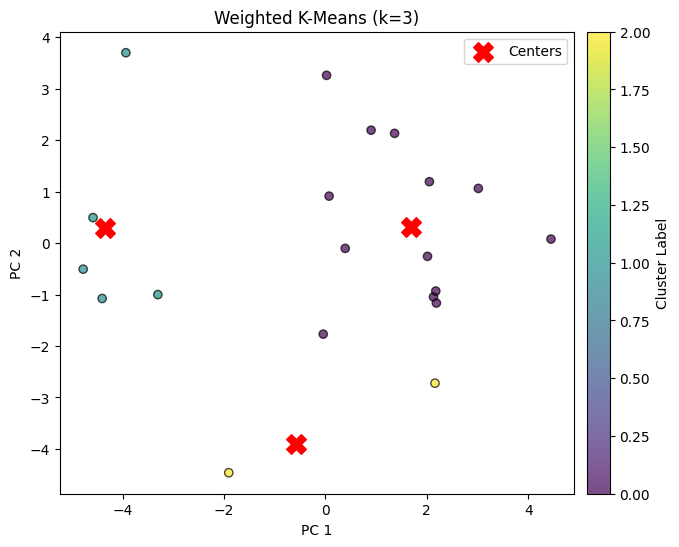

In [ ]:
label, centers = weighted_cluster_param_sets_and_plot(selected_params, selected_df["score"], n_clusters=3)

In [ ]:
centers

array([[-0.71008922,  2.61938938,  2.5887754 ,  2.51246004],
       [-5.71537591,  3.00531492,  2.14467184,  5.82611908],
       [-0.18517531,  1.09094377,  2.74556502,  7.65252428]])

In [180]:
input_file = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH-optim-spreadsheet.csv"
output_dir = "/content/drive/MyDrive/DAO token valuation paper/week5/ETH Calibration/thesis_v7 ETH-optim-spreadsheet_per_run"

pros, metr, eval = evaluation_pipeline(input_file, output_dir, real_price, W)
metr

processed. computing metrics per run
metrics computed per run. Now aggregating metrics by calibration parameters


,log10initial-productivity,productivity-mu,productivity-sigma,transaction-need-std,price,mae,std,Kurt,hurst
0,-0.710089,2.619389,2.588775,2.51246,"[0.0029215123734433, 0.0810862318743251, 0.427...",3.846332e+02,1.024906e+03,13.201622,0.861381
1,-0.710089,2.619389,2.588775,2.51246,"[0.0262889571848436, 1.5578734536706955, 10.27...",1.732269e+06,3.571829e+06,11.374878,0.840666
2,-0.710089,2.619389,2.588775,2.51246,"[0.0014947373332673, 0.0922822514324094, 1.545...",2.069608e+02,1.757567e+01,24.546821,0.847509
3,-0.710089,2.619389,2.588775,2.51246,"[0.0052335070852202, 0.0979907304137647, 0.721...",2.010590e+02,5.073827e+02,7.131793,0.877022
4,-0.710089,2.619389,2.588775,2.51246,"[0.0126947353211761, 0.5878654684217842, 3.530...",1.563306e+04,3.080837e+04,16.913195,0.807270
...,...,...,...,...,...,...,...,...,...
95,-0.710089,2.619389,2.588775,2.51246,"[0.0213135802406288, 0.1373388589456958, 0.356...",1.862899e+02,2.490407e+01,5.995098,0.795396
96,-0.710089,2.619389,2.588775,2.51246,"[0.0029498457786534, 0.0269526727681987, 0.093...",2.065721e+02,4.213729e+00,8.438820,0.873873
97,-0.710089,2.619389,2.588775,2.51246,"[0.0266679689809445, 0.3325685067750449, 1.118...",2.485935e+03,8.893164e+03,29.451022,0.791803
98,-0.710089,2.619389,2.588775,2.51246,"[0.0166969134025417, 0.9463102230597144, 8.281...",8.010740e+02,2.127728e+03,14.546346,0.831300


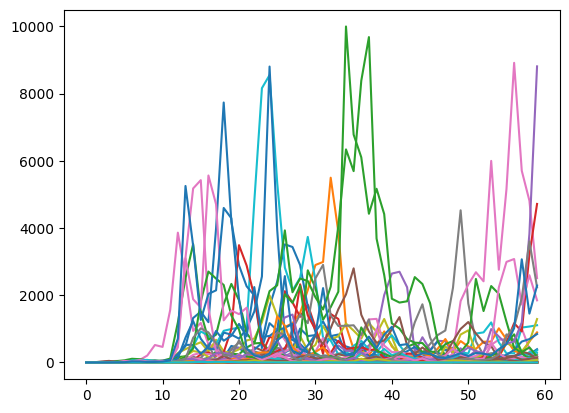

In [ ]:
plt.plot(real_price)
for series in pros["price"]:
    if series.max() < 10000:
        plt.plot(series)

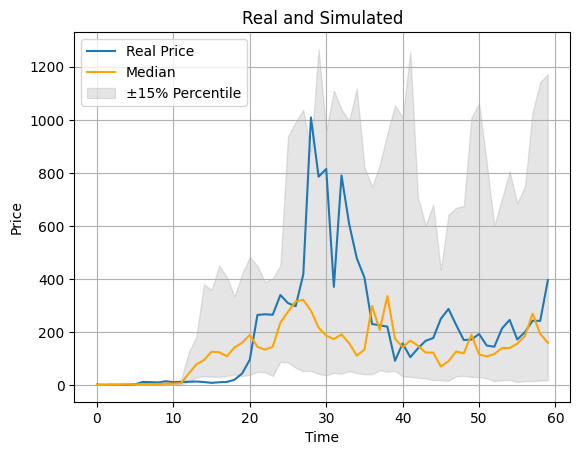

In [186]:
plt.plot(real_price, label="Real Price")

price_array = np.array(pros['price'].tolist())

# Calculate mean, median, 25th and 75th percentiles over rows (axis=0)
mean_series = np.mean(price_array, axis=0)
median_series = np.median(price_array, axis=0)
p25_series = np.percentile(price_array, 35, axis=0)
p75_series = np.percentile(price_array, 65, axis=0)

# Create an x-axis for plotting; this assumes price lists are all the same length
time = np.arange(price_array.shape[1])

# Plot the median series
plt.plot(time, median_series, label='Median', color='orange')

# Fill between 25th and 75th percentiles
plt.fill_between(time, p25_series, p75_series, color='gray', alpha=0.2, label='±15% Percentile')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real and Simulated')
plt.legend()
plt.grid(True)
plt.show()

In [179]:
np.std(real_price)
kurtosis(real_price)
hurst(real_price)

0.9145892814433347

In [185]:
pd.DataFrame([[np.std(real_price), kurtosis(real_price), hurst(real_price)],
[metr["std"].median(), metr["Kurt"].median(), metr["hurst"].median()]])

,0,1,2
0,222.113361,2.742500,0.914589
1,1026.819365,11.460266,0.851982
